In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [2]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures"""

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Create a list with the filepaths
train_dir = Path('../input/wildfire-prediction-dataset/train')
filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir=Path('../input/wildfire-prediction-dataset/test')
filepaths_test = list(test_dir.glob(r'**/*.jpg'))
val_dir=Path('../input/wildfire-prediction-dataset/valid')
filepaths_valid = list(val_dir.glob(r'**/*.jpg'))
# Create a DataFrame with the filepaths and the labels of the picture
df_train = proc_img(filepaths)
df_test = proc_img(filepaths_test)
df_valid=proc_img(filepaths_valid)

In [3]:
def print_df(df):

    print(f'Number of pictures: {df.shape[0]}\n')
    print(f'Number of different labels: {len(df.Label.unique())}\n')
    print(f'Labels: {df.Label.unique()}')

    # The DataFrame with the filepaths in one column and the labels in the other one
    print(df.head(5))

In [4]:
print_df(df_train)

Number of pictures: 30250

Number of different labels: 2

Labels: ['nowildfire' 'wildfire']
                                            Filepath       Label
0  ../input/wildfire-prediction-dataset/train/now...  nowildfire
1  ../input/wildfire-prediction-dataset/train/now...  nowildfire
2  ../input/wildfire-prediction-dataset/train/now...  nowildfire
3  ../input/wildfire-prediction-dataset/train/now...  nowildfire
4  ../input/wildfire-prediction-dataset/train/now...  nowildfire


In [5]:
print_df(df_test)

Number of pictures: 6300

Number of different labels: 2

Labels: ['wildfire' 'nowildfire']
                                            Filepath       Label
0  ../input/wildfire-prediction-dataset/test/wild...    wildfire
1  ../input/wildfire-prediction-dataset/test/wild...    wildfire
2  ../input/wildfire-prediction-dataset/test/nowi...  nowildfire
3  ../input/wildfire-prediction-dataset/test/wild...    wildfire
4  ../input/wildfire-prediction-dataset/test/nowi...  nowildfire


In [6]:
print_df(df_valid)

Number of pictures: 6300

Number of different labels: 2

Labels: ['wildfire' 'nowildfire']
                                            Filepath       Label
0  ../input/wildfire-prediction-dataset/valid/wil...    wildfire
1  ../input/wildfire-prediction-dataset/valid/now...  nowildfire
2  ../input/wildfire-prediction-dataset/valid/now...  nowildfire
3  ../input/wildfire-prediction-dataset/valid/wil...    wildfire
4  ../input/wildfire-prediction-dataset/valid/now...  nowildfire


In [7]:
def viz_img(df):

    # Create a DataFrame with one Label of each category
    df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

    # Display 40 picture of the dataset
    fig, axes = plt.subplots(ncols=2, figsize=(15, 7),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
    #     ax.set_title(df_unique.Label[i])
    plt.tight_layout(pad=0.5)
    plt.show()

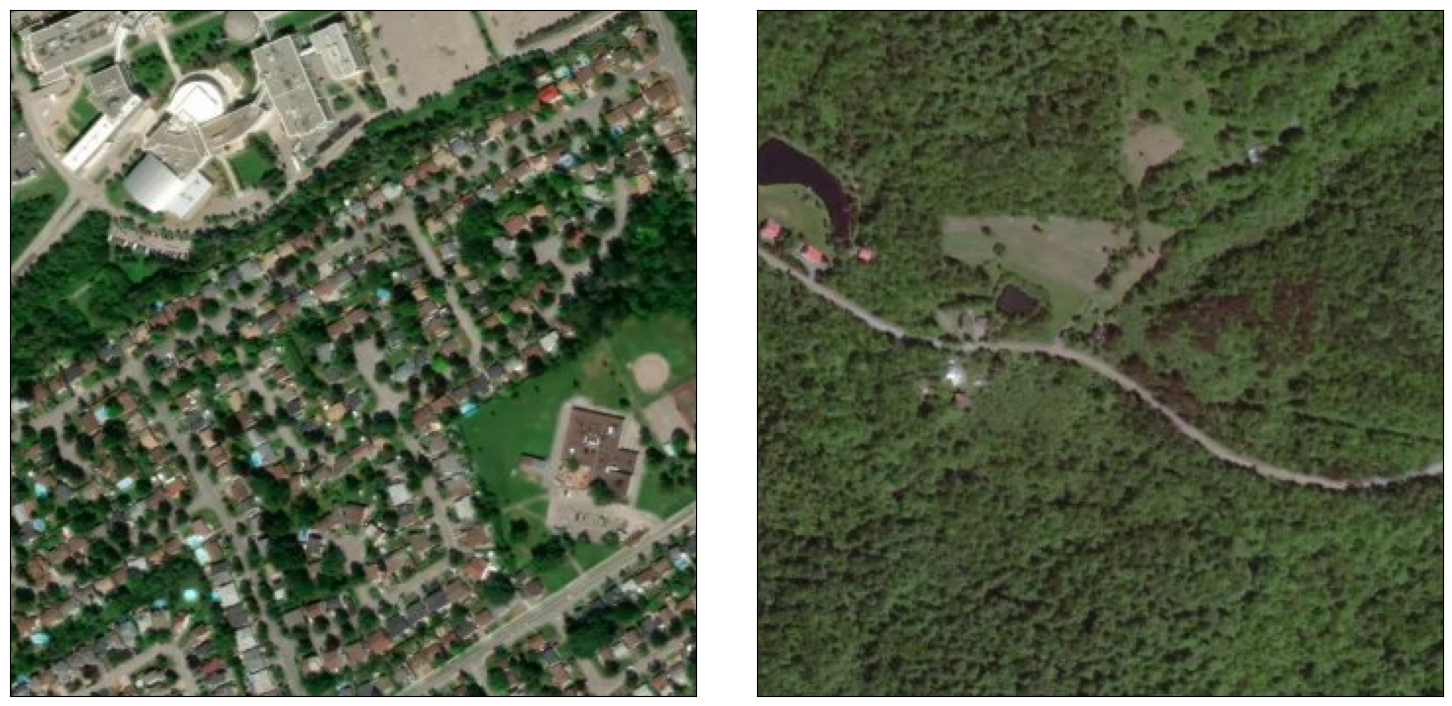

In [8]:
viz_img(df_train)

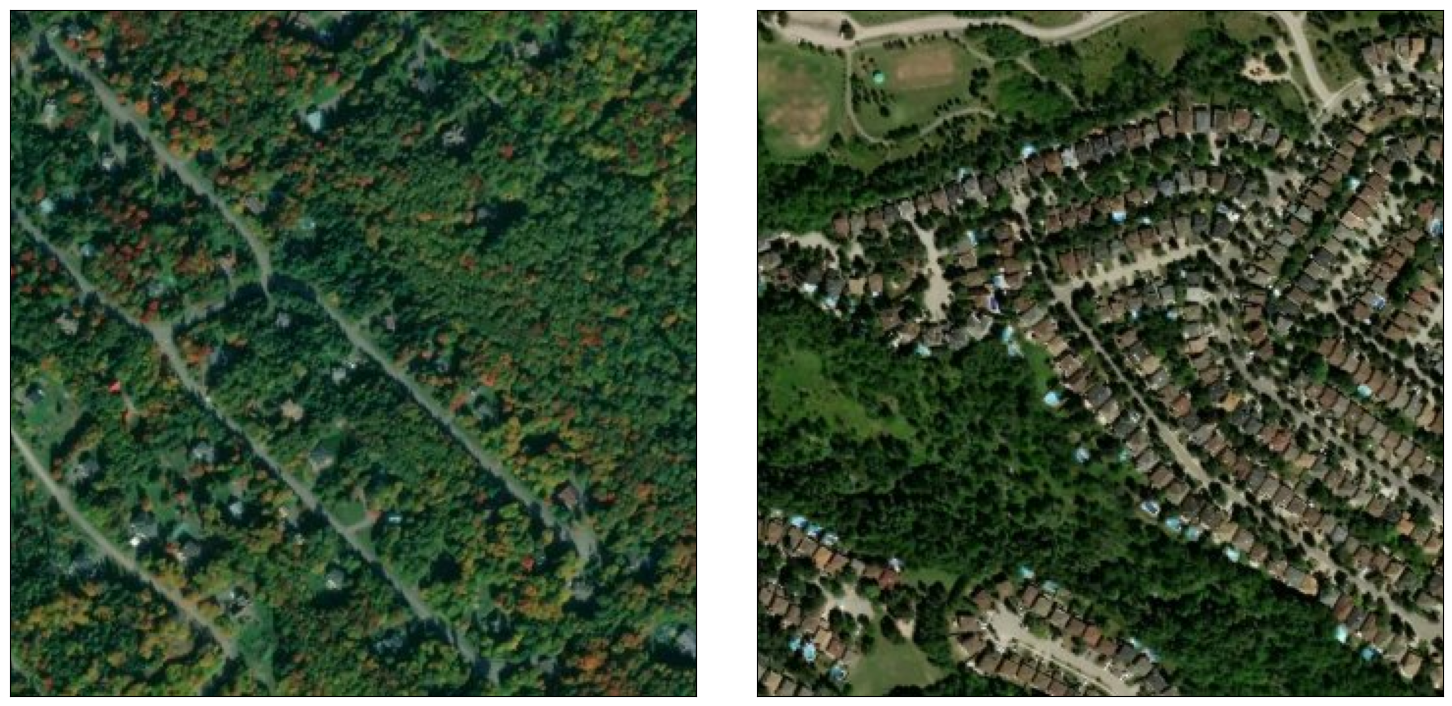

In [9]:
viz_img(df_test)

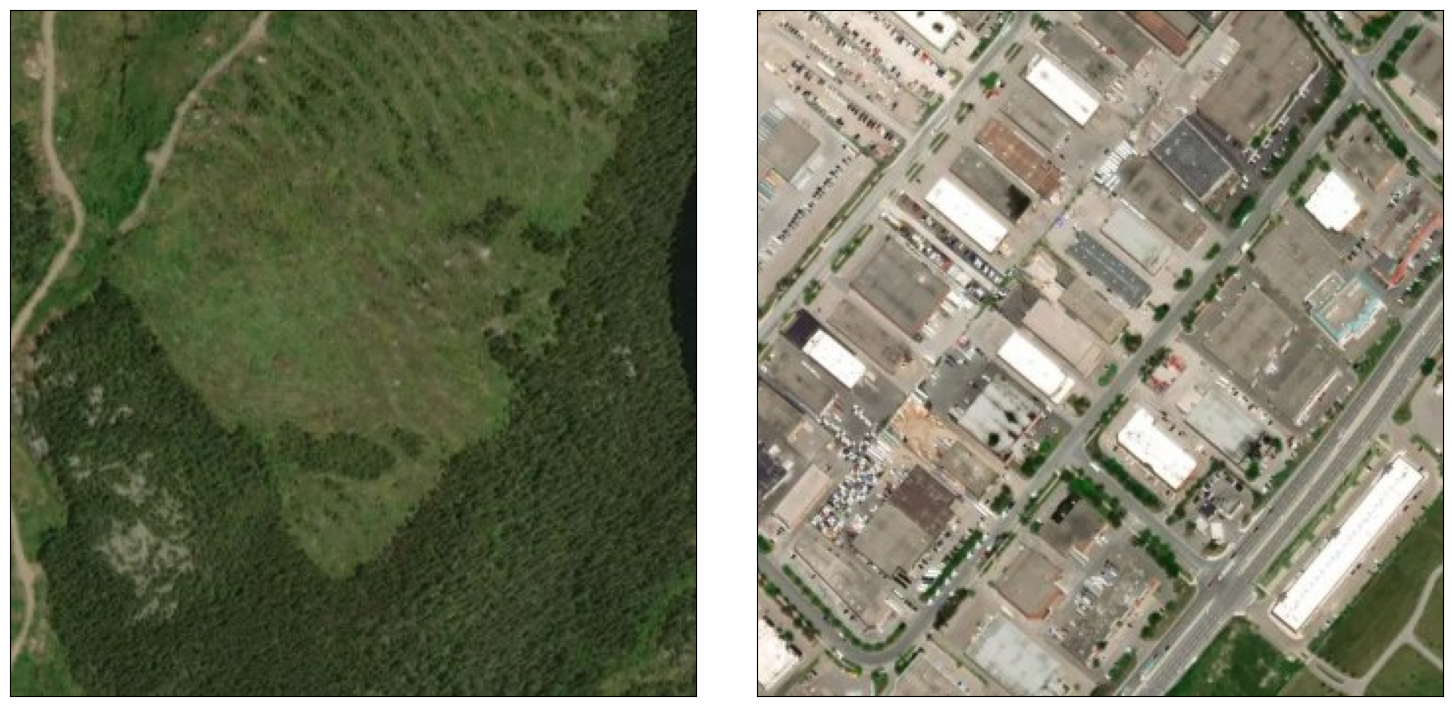

In [10]:
viz_img(df_valid)

In [11]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=df_train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=df_train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=df_test,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [12]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [13]:
models = {
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0}
}
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 27225 validated image filenames belonging to 2 classes.
Found 3025 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725631062.453741     121 service.cc:145] XLA service 0x7fd3e4006ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725631062.453816     121 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725631062.453821     121 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725631068.607927     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


MobileNet            trained in 299.26 sec


In [14]:
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  val_accuracy  Training time (sec)
0  MobileNet        0.9636               299.26

In [15]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Get the model with the highest validation score
best_model = df_results.iloc[0]

# Create a new model
model = get_model( eval("tf.keras.applications."+ best_model[0]) )

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True)]
                    )

Found 27225 validated image filenames belonging to 2 classes.
Found 3025 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


/tmp/ipykernel_36/3164590043.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = get_model( eval("tf.keras.applications."+ best_model[0]) )


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


851/851 ━━━━━━━━━━━━━━━━━━━━ 92s 102ms/step - accuracy: 0.9370 - loss: 0.1610 - val_accuracy: 0.9488 - val_loss: 0.1345
Epoch 2/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.9670 - loss: 0.0897 - val_accuracy: 0.9640 - val_loss: 0.0941
Epoch 3/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 83s 97ms/step - accuracy: 0.9740 - loss: 0.0690 - val_accuracy: 0.9683 - val_loss: 0.0931
Epoch 4/5
851/851 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.9810 - loss: 0.0523 - val_accuracy: 0.9663 - val_loss: 0.1037


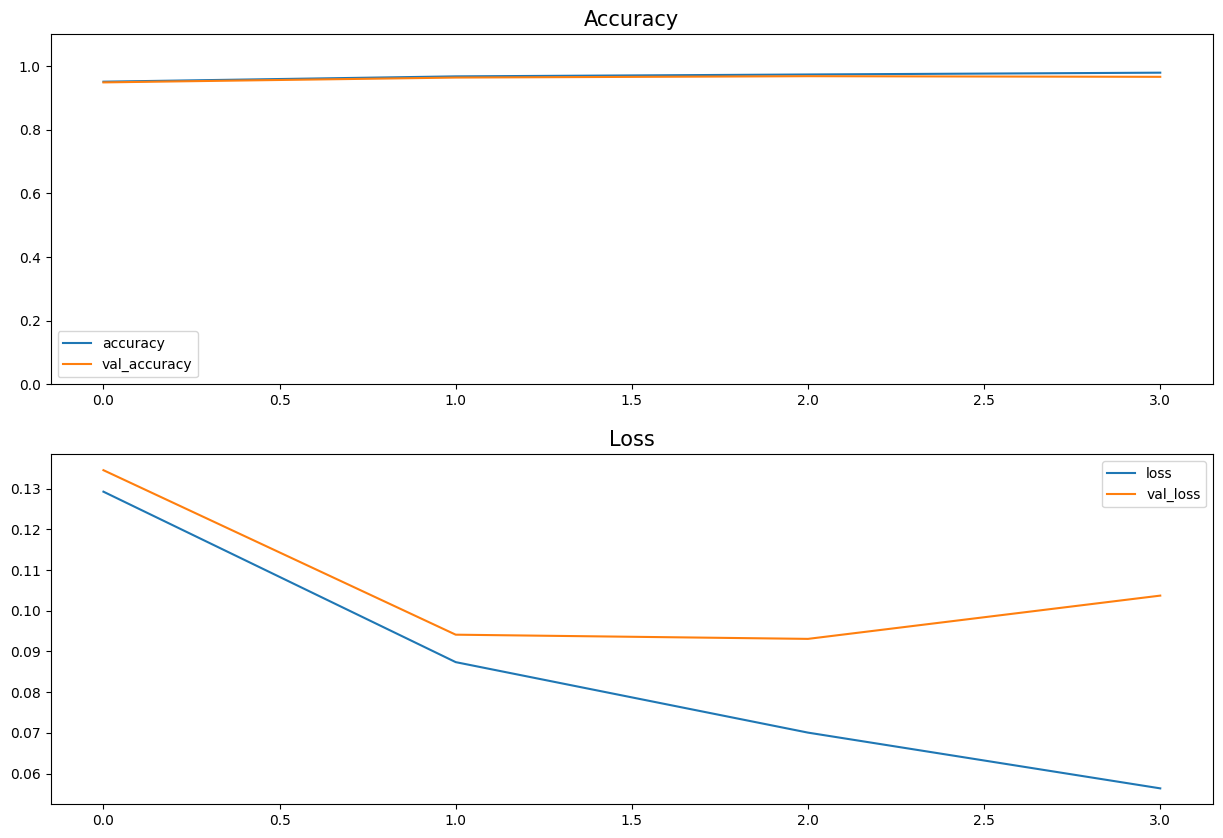

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


197/197 ━━━━━━━━━━━━━━━━━━━━ 64s 318ms/step


/tmp/ipykernel_36/1590172651.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  printmd(f'## Best Model: {best_model[0]} with {acc*100:.2f}% accuracy on the test set')


## Best Model: MobileNet with 97.71% accuracy on the test set

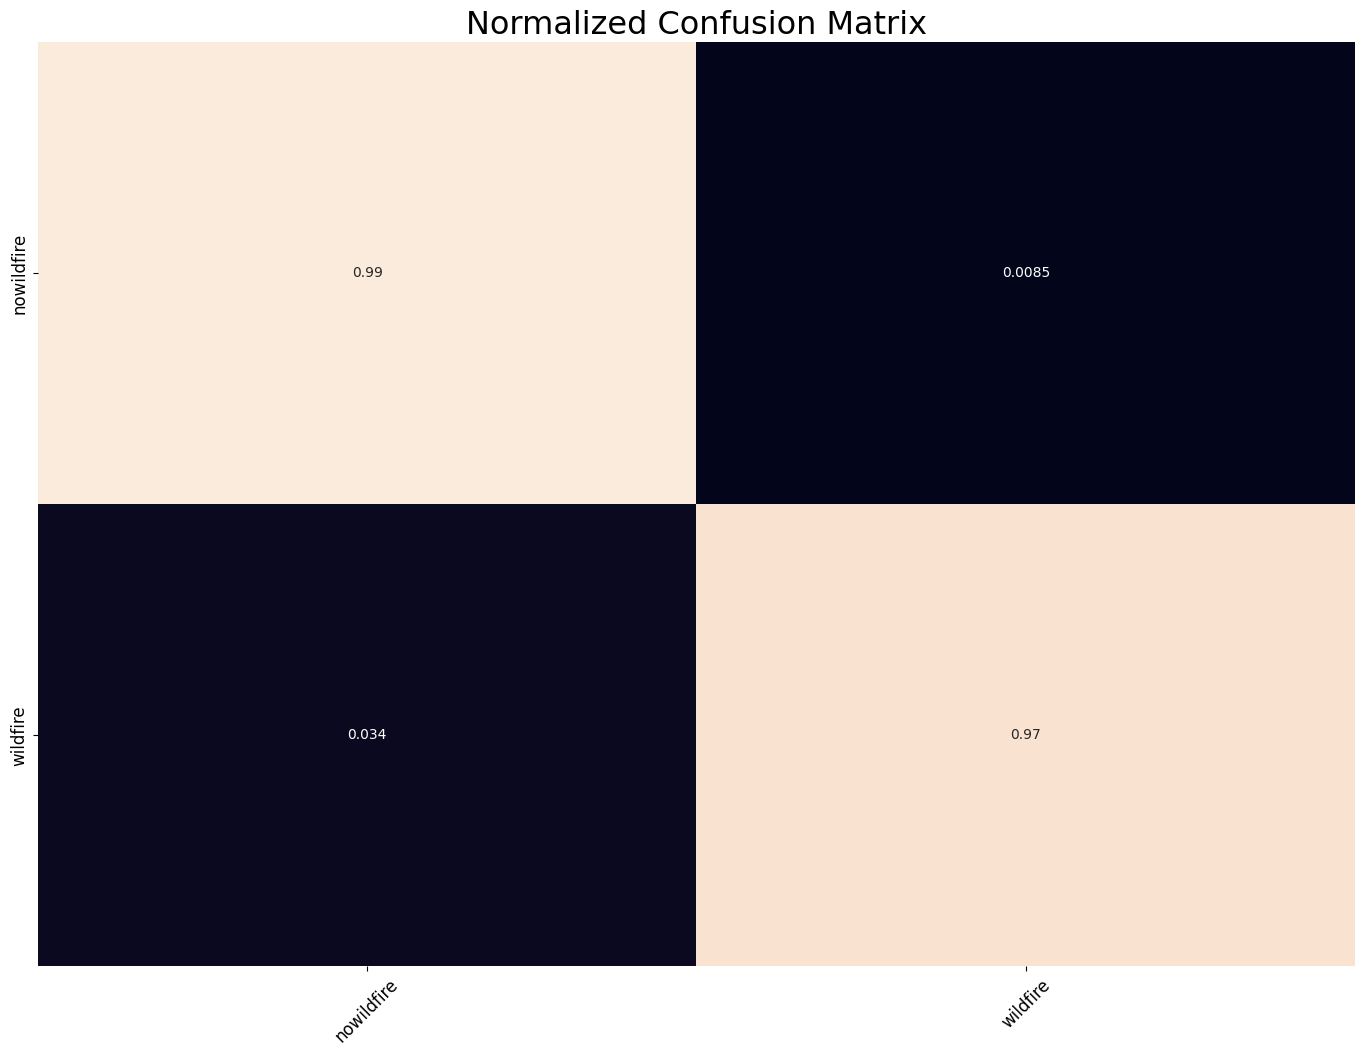

In [17]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(df_test.Label)
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## Best Model: {best_model[0]} with {acc*100:.2f}% accuracy on the test set')

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()